In [1]:
import cv2
import keras
from keras import backend as K
from keras.models import load_model
from keras.preprocessing.image import array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


In [2]:
%matplotlib inline

In [3]:
INPUT_SIZE = 299

In [4]:
model = load_model('model_16.h5')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [5]:
def grad_cam(input_model, x, layer_name):
    """
    Args:
       input_model: Model object
       x: image (array)
       layer_name: Name of conv layer

    Returns:
       jetcam: Processed image (array)
    """

    # Pre processing
    X = np.expand_dims(x, axis=0)
    X = X.astype('float32')
    preprocessed_input = X / 255.0

    # Prediction
    predictions = model.predict(preprocessed_input)
    class_idx = np.argmax(predictions[0])
    class_output = model.output[:, class_idx]

    # Get gradient
    conv_output = model.get_layer(
        layer_name).output  # Output layer: layer_name
    # Return gradient of varidation's loss with gradients(loss, variables)
    grads = K.gradients(class_output, conv_output)[0]
    # Output conv_output and grads by model.input
    gradient_function = K.function([model.input], [conv_output, grads])

    output, grads_val = gradient_function([preprocessed_input])
    output, grads_val = output[0], grads_val[0]

    # Averaging weights, multiply the output of the layer
    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # Make heatmap
    cam = cv2.resize(cam, (INPUT_SIZE, INPUT_SIZE), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()

    jetcam = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    jetcam = cv2.cvtColor(jetcam, cv2.COLOR_BGR2RGB)
    jetcam = (np.float32(jetcam) + x / 2)

    return jetcam

In [6]:
def display_grad_cam(image_path):
    x = img_to_array(load_img(image_path, target_size=(INPUT_SIZE, INPUT_SIZE)))
    plt.subplot(1, 2, 1)
    plt.imshow(x.astype('uint8'))
    
    x_ = grad_cam(model, x, 'mixed10')
    plt.subplot(1, 2, 2)
    plt.imshow(x_.astype('uint8'))
    
    plt.show()

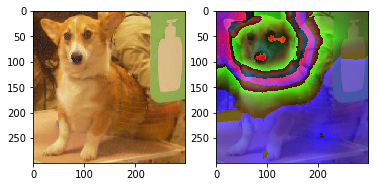

In [7]:
display_grad_cam('/home/skcvim/Downloads/f')

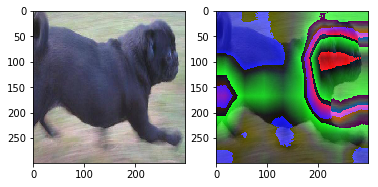

In [8]:
display_grad_cam('../data/crop/pug/pug_000_0.jpg')